In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies
from vortexasdk.utils import convert_to_list

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

In [2]:
# Defining date range for historical analysis
# NB: Vortexa data is currently available from 2016-01-01 with a maximum date range of 4 years per query 
START_DATE = datetime(2019, 6, 1)
END_DATE = datetime(2020, 6, 1)
DATE_RANGE = pd.date_range(START_DATE, END_DATE)

# Define floating storage unit (t = metric tonnes, b = barrels)
UNIT = 'b'

In [3]:
def get_product_id_exact(product_name):
    if product_name is None:
        return None
    
    products = [p.id for p in Products().search(product_name).to_list() if p.name==product_name]    
    assert len(products) == 1
    return products[0]

In [4]:
def get_geography_id_exact(geog_name):
    if geog_name is None:
        return None
    
    geogs = [g.id for g in Geographies().search(geog_name).to_list() if g.name==geog_name]    
    assert len(geogs) == 1
    return geogs[0]

In [5]:
from functools import reduce

def merge(data_frames):
    return reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="outer"
        ),
        data_frames,
    )

In [6]:
def plot_df(df, title=None, unit=UNIT):
    df.plot(title=title, grid=True)
    plt.xlabel('date')
    plt.ylabel('k' + unit);

In [7]:
def prepare_dataset(df_fs, product_names, destination_names, storage_names, filter_activity):

    # just keep key and value
    df_fs = df_fs[['key', 'value']]

    # use kilotonnes not tonnes
    df_fs['value'] = df_fs['value'] / 1000


    # rename columns
    col_name = str((destination_names or " ")) + \
        " " + str((storage_names) or " ") + \
        " " + str((product_names) or " ") + \
        ": " + filter_activity

    df_fs = df_fs.rename(columns={'key': 'date', 'value': col_name})

    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)


    return df_fs.set_index('date')

In [8]:
def fetch_timeseries(filter_activity, product_names=None, destination_names=None, storage_names=None,
                    unit=UNIT, frequency='day'):
    
    # Generate IDs
    product_ids = [get_product_id_exact(name) for name in convert_to_list(product_names)]
    destination_ids = [get_geography_id_exact(name) for name in convert_to_list(destination_names)]
    storage_ids = [get_geography_id_exact(name) for name in convert_to_list(storage_names)]
    
    
    # Load Data
    df = CargoTimeSeries().search(timeseries_frequency=frequency,
                                     timeseries_unit=unit,
                                     disable_geographic_exclusion_rules=True,
                                     filter_products=product_ids,
                                     filter_destinations=destination_ids,
                                     filter_storage_locations=storage_ids,
                                     filter_activity=filter_activity,
                                     filter_time_min=START_DATE,
                                     filter_time_max=END_DATE).to_df()

    # Rename columns, set index etc
    return prepare_dataset(df, product_names, destination_names, storage_names, filter_activity)
    


In [9]:
# Define constants

clean = "Clean Petroleum Products"
naphtha = "Naphtha"
diesel_gasoil = "Diesel/Gasoil"
gasoline_blending_components = "Gasoline/Blending Components"
jet_kero = "Jet/Kero"

In [10]:
# What is floating Storage?

In [17]:
clean_fs = fetch_timeseries("storing_state", clean)
clean_fs.head()

Clean Petroleum Products


,Clean Petroleum Products: storing_state
date,
2019-06-01,30024.858
2019-06-02,31562.575
2019-06-03,33723.654
2019-06-04,31512.204
2019-06-05,32108.163


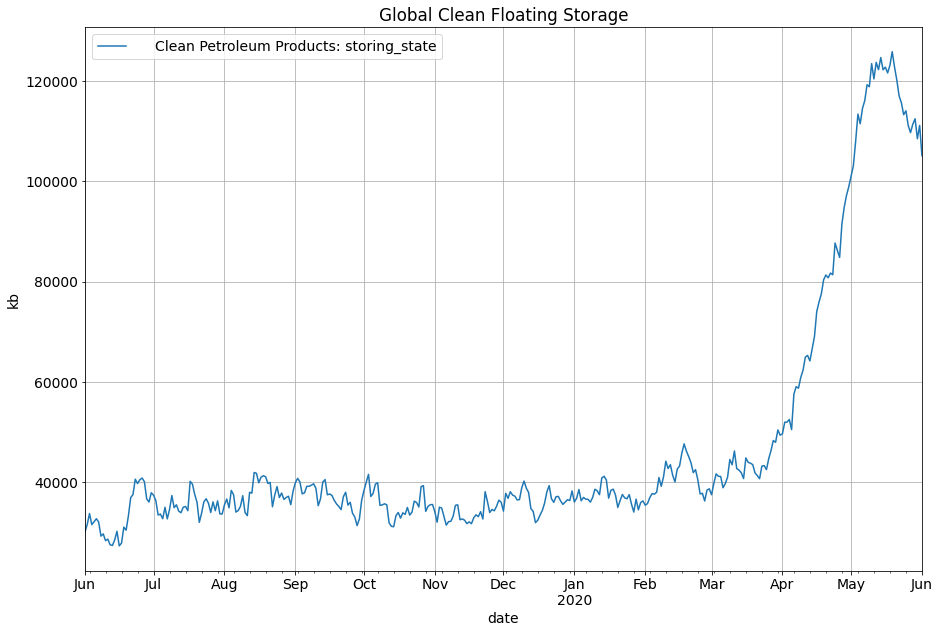

In [37]:
plot_df(clean_fs, "Global Clean Floating Storage")

In [38]:
data_frames = [
    fetch_timeseries("storing_state", gasoline_blending_components),
    fetch_timeseries("storing_state", diesel_gasoil),
    fetch_timeseries("storing_state", naphtha),
    fetch_timeseries("storing_state", jet_kero)
]

df_merged = merge(data_frames)
df_merged.head()

,Gasoline/Blending Components: storing_state,Diesel/Gasoil: storing_state,Naphtha: storing_state,Jet/Kero: storing_state
date,,,,
2019-06-01,6238.790,12603.699,2293.203,838.280
2019-06-02,6881.770,13173.404,2592.860,686.854
2019-06-03,8374.851,13461.806,2725.593,686.854
2019-06-04,8797.118,12328.874,2116.603,679.369
2019-06-05,7675.214,12701.082,3163.179,359.471


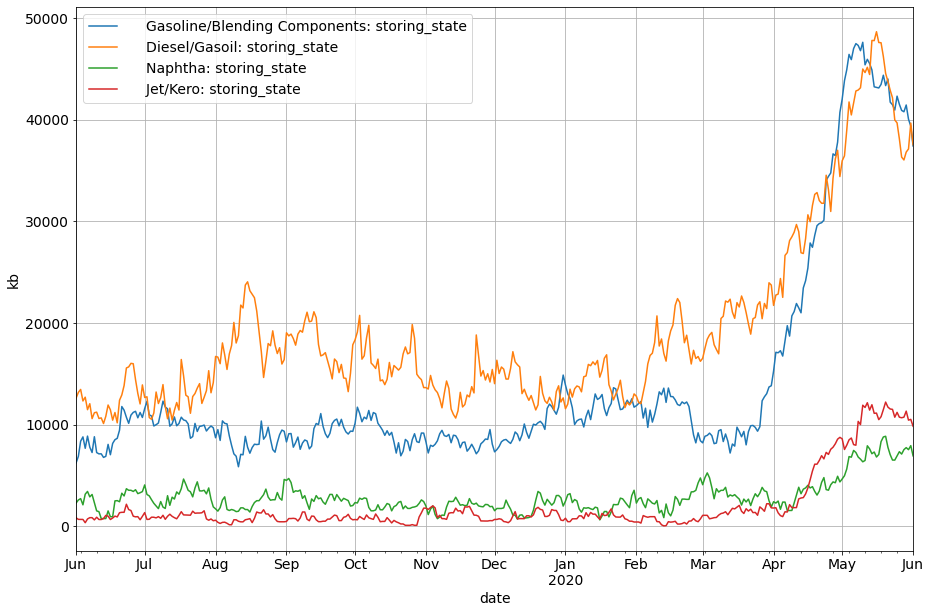

In [39]:
plot_df(df_merged)

In [22]:
dfs_asia = [
    fetch_timeseries("storing_state", storage_names="Asia", product_names=gasoline_blending_components),
    fetch_timeseries("storing_state", storage_names="Asia", product_names=diesel_gasoil),
    fetch_timeseries("storing_state", storage_names="Asia", product_names=naphtha),
    fetch_timeseries("storing_state", storage_names="Asia", product_names=jet_kero)
]

df_asia = merge(dfs_asia)
df_asia.head()

Gasoline/Blending Components
Diesel/Gasoil
Naphtha
Jet/Kero


,Asia Gasoline/Blending Components: storing_state,Asia Diesel/Gasoil: storing_state,Asia Naphtha: storing_state,Asia Jet/Kero: storing_state
date,,,,
2019-06-01,742.098,7062.437,273.543,96.057
2019-06-02,709.744,7002.741,273.543,0.000
2019-06-03,873.779,7091.773,410.868,0.000
2019-06-04,800.032,6855.074,410.868,0.000
2019-06-05,389.214,6778.808,725.194,0.000


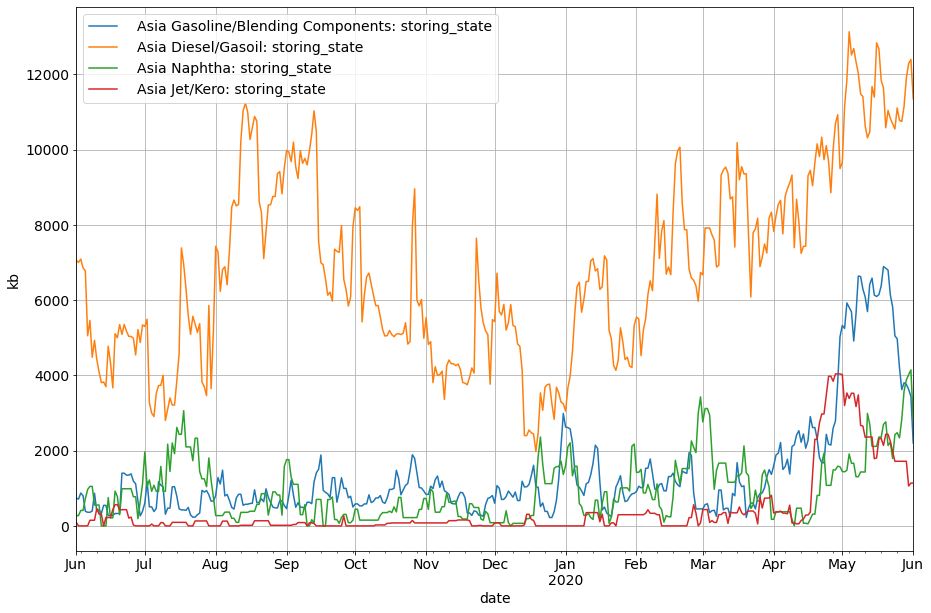

In [23]:
plot_df(df_asia)

In [12]:
dfs_diesel_gasoil_countries = [
    fetch_timeseries("storing_state", product_names=diesel_gasoil, storage_names="South Korea"),
    fetch_timeseries("storing_state", product_names=diesel_gasoil, storage_names="India"),
    fetch_timeseries("storing_state", product_names=diesel_gasoil, storage_names="China"),
    fetch_timeseries("storing_state", product_names=diesel_gasoil, storage_names=["Singapore", "Malaysia", "Indonesia"])
]

df_diesel_gasoil_countries = merge(dfs_diesel_gasoil_countries)
df_diesel_gasoil_countries.head()

Diesel/Gasoil
Diesel/Gasoil
Diesel/Gasoil
Diesel/Gasoil


,None South Korea Diesel/Gasoil: storing_state,None India Diesel/Gasoil: storing_state,None China Diesel/Gasoil: storing_state,"None ['Singapore', 'Malaysia', 'Indonesia'] Diesel/Gasoil: storing_state"
date,,,,
2019-06-01,0.0,201.694,2524.509,2922.550
2019-06-02,0.0,201.694,2524.509,2862.854
2019-06-03,0.0,175.422,3743.885,1768.625
2019-06-04,0.0,477.967,3058.555,1718.049
2019-06-05,0.0,313.533,3082.525,1499.741


In [ ]:
plot_df(df_diesel_gasoil_countries)

# Asia imports market chart:

In [10]:
dfs_imports = [
    fetch_timeseries("unloading_state", diesel_gasoil, unit='bpd', frequency='month', destination_names="Australia"),
    fetch_timeseries("unloading_state", diesel_gasoil, unit='bpd', frequency='month', destination_names=["Singapore", "Malaysia", "Indonesia"]),
    fetch_timeseries("unloading_state", diesel_gasoil, unit='bpd', frequency='month', destination_names="Philippines"),
    fetch_timeseries("unloading_state", diesel_gasoil, unit='bpd', frequency='month', destination_names="Vietnam")
]

df_imports = merge(dfs_imports)

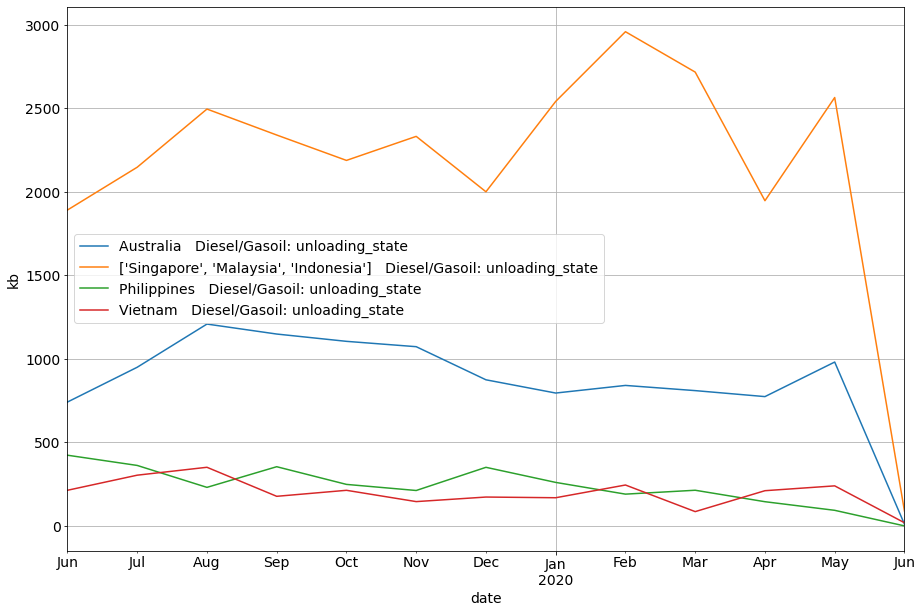

In [11]:
plot_df(df_imports)